# Overall Workflow
## 1. The Dataset
## 2. Preprocessing Before Modeling
## 3. Model Fitting
## 4. Hyperparameter Tuning - SGD classifier
## 5. Result comparison
## 6. Summary

# Packages

In [1]:
# Data structures
import numpy as np
import pandas as pd

# Data formats
import csv
import json

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sb

# Statistical testings
from scipy.stats import f
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

# Data preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine learning algorithm
from sklearn.linear_model import SGDClassifier

# Hyperparameter tuning
from hyperopt import hp
from hyperopt import Trials
from hyperopt import tpe
from timeit import default_timer as timer
from hyperopt import STATUS_OK
from hyperopt import fmin

# Model validation
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix

# Improvement
from imblearn.over_sampling import SMOTE

# 1. The Dataset

In [2]:
data = pd.read_csv('banking.csv')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [3]:
# 41188 data points with 21 predictors
print(data.shape)

(41188, 21)


In [4]:
# Since the purpose is to build a prediction model, I dropped this column from the feature space.
data.drop(columns='duration', inplace=True)
print(data.shape)

(41188, 20)


# 2. Preprocessing Before Modeling
- 2.1 One-hot encoding
- 2.2 Dummy feature generation
- 2.3 Improvement: Over-sampling using SMOTE
- 2.4 Train & test splitting (80%/20%)
- 2.5 Standardization
    - Why standardization is needed? -> Regularization purpose.

## 2.1 One-hot encoding

In [5]:
dummy_features = []
binary_features = []
for each in data.columns:
    if data[each].dtype == 'object':
        if len(data[each].unique()) > 2:
            dummy_features.append(each)
        else: 
            binary_features.append(each)

In [6]:
# One-hot encoding for categorical features containing two levels
le = LabelEncoder()
le_count = 0

for col in binary_features:
    print(col)
    le.fit(data[col])
    data[col] = le.transform(data[col])
            
    # Keep track of how many columns were label encoded
    le_count += 1
            
print('%d columns were label encoded.' % le_count)

contact
1 columns were label encoded.


In [7]:
# Make sure the transformation is correct!
# 0: cellular
# 1: telephone
data['contact'].unique()

array([0, 1])

## 2.2 Dummy feature generation

In [8]:
# Create dummy features
sum_len = 0
for col in dummy_features:
    sum_len += len(data[col].unique())
    print(col, len(data[col].unique()))
    
print('{} columns will be additionally added.'.format(sum_len - len(dummy_features)))

job 12
marital 4
education 8
default 3
housing 3
loan 3
month 10
day_of_week 5
poutcome 3
42 columns will be additionally added.


In [9]:
# Original dimension
print(data.shape)

# 20 + 42 = 62, correct dummy feature transformation!
data = pd.get_dummies(data, columns = dummy_features)
print(data.shape)

(41188, 20)
(41188, 62)


In [10]:
data.head()

,age,contact,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,44,0,1,999,0,1.4,93.444,-36.1,4.963,5228.1,...,0,0,0,0,1,0,0,0,1,0
1,53,0,1,999,0,-0.1,93.200,-42.0,4.021,5195.8,...,0,0,1,0,0,0,0,0,1,0
2,28,0,3,6,2,-1.7,94.055,-39.8,0.729,4991.6,...,0,0,0,0,1,0,0,0,0,1
3,39,0,2,999,0,-1.8,93.075,-47.1,1.405,5099.1,...,0,0,1,0,0,0,0,0,1,0
4,55,0,1,3,1,-2.9,92.201,-31.4,0.869,5076.2,...,0,0,1,0,0,0,0,0,0,1


## 2.3 Improvement: Over-sampling using SMOTE 

In [11]:
# Notice that I over-sampled only on the training data, 
# because by oversampling only on the training data, 
# none of the information in the testing data is being used to create synthetic observations.
# Therefore, the information in the testing data will not contaminate the training data.
os = SMOTE(sampling_strategy='minority', k_neighbors=10, m_neighbors=20, random_state=0)
os_data_X, os_data_y = os.fit_sample(data[data.columns.difference(['y'])], 
                                     data.y)
os_data_X = pd.DataFrame(data=os_data_X, columns=data.columns.difference(['y']))
os_data_y = pd.DataFrame(data=os_data_y,columns=['y'])

# Check the numbers of over-sampled data
print("length of oversampled data is ", len(os_data_X))
print("Number of no subscription in oversampled data", len(os_data_y[os_data_y['y'] == 0]))
print("Number of subscription", len(os_data_y[os_data_y['y'] == 1]))
print("Proportion of no subscription data in oversampled data is ",
      len(os_data_y[os_data_y['y'] == 0])/len(os_data_y))
print("Proportion of subscription data in oversampled data is ",
      len(os_data_y[os_data_y['y'] == 1])/len(os_data_y))

length of oversampled data is  73096
Number of no subscription in oversampled data 36548
Number of subscription 36548
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


## 2.4 Train & test splitting (80%/20%)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(os_data_X, 
                                                    os_data_y, 
                                                    test_size=0.2, random_state=0) 

In [13]:
# Make sure the splitting is correct!
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(58476, 61) (14620, 61)
(58476, 1) (14620, 1)


## 2.5 Standardization

In [14]:
# Test data are unseen data! 
# Since my purpose is to build a prediction model, I shouldn't contaminate train and test data together. 
std_scaler = StandardScaler().fit(x_train)

train_standardized_data = std_scaler.transform(x_train)
test_standardized_data = std_scaler.transform(x_test)

In [15]:
# Make sure the standardization is correct (mean must be 0 and variance must be 1) 
# Train data
pd.DataFrame(train_standardized_data).describe()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
count,5.847600e+04,5.847600e+04,5.847600e+04,5.847600e+04,5.847600e+04,5.847600e+04,5.847600e+04,5.847600e+04,5.847600e+04,5.847600e+04,...,5.847600e+04,5.847600e+04,5.847600e+04,5.847600e+04,5.847600e+04,5.847600e+04,5.847600e+04,5.847600e+04,5.847600e+04,5.847600e+04
mean,-1.002020e-14,6.748655e-17,-6.869270e-14,-2.301517e-11,3.667442e-15,-3.870341e-15,-3.901273e-16,1.718602e-15,1.675090e-15,-2.863487e-15,...,-1.329894e-15,-4.945292e-16,1.779803e-15,1.507841e-15,1.183280e-11,-3.371684e-15,1.082046e-15,2.154010e-15,-1.583188e-15,-1.971310e-15
std,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,...,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00
min,-1.962015e+00,-5.680033e-01,-1.983291e+00,-2.026413e+00,-6.322546e-01,-5.095551e-01,-5.276203e-01,-5.619754e-01,-5.346215e-01,-5.361716e-01,...,-6.139690e-01,-3.350478e-01,-2.040029e-01,-1.854645e-01,-1.984152e+00,-2.851768e+00,-3.683961e-01,-1.983339e+00,-3.412183e-01,-4.575588e-01
25%,-7.633044e-01,-5.680033e-01,-4.652984e-01,-8.507732e-01,-6.322546e-01,-5.095551e-01,-5.276203e-01,-5.619754e-01,-5.346215e-01,-5.361716e-01,...,-6.139690e-01,-3.350478e-01,-2.040029e-01,-1.854645e-01,-6.875851e-01,3.529286e-01,-3.683961e-01,5.307416e-01,-3.412183e-01,-4.575588e-01
50%,-1.997150e-01,-1.843367e-01,-2.966325e-01,-5.559780e-02,-6.322546e-01,-5.095551e-01,-5.276203e-01,-5.619754e-01,-5.346215e-01,-5.361716e-01,...,-6.139690e-01,-3.350478e-01,-2.040029e-01,-1.854645e-01,6.343143e-01,3.529286e-01,-3.683961e-01,5.307416e-01,-3.412183e-01,-4.575588e-01
75%,6.394753e-01,2.584066e-01,7.153626e-01,8.164442e-01,1.645423e+00,-5.095551e-01,-4.646568e-01,5.189206e-02,-2.971104e-01,-2.754336e-01,...,1.657902e+00,-3.350478e-01,-2.040029e-01,-1.854645e-01,1.061513e+00,3.529286e-01,-3.683961e-01,5.307416e-01,-3.412183e-01,-4.575588e-01
max,4.835427e+00,2.323110e+01,2.495724e+00,2.042060e+00,1.657076e+00,2.238409e+00,2.150412e+00,2.026440e+00,2.141712e+00,2.135584e+00,...,1.657902e+00,3.104917e+00,5.185049e+00,5.793828e+00,1.061513e+00,3.529286e-01,3.026884e+00,5.307416e-01,2.984327e+00,1.018560e+01


# 3. Model Fitting
- 3.1 Model validation - Five-folds Cross Validation
- 3.2 Model performance report

## 3.1 Model validation - Five-folds Cross Validation

In [16]:
# The first model is trained on balanced lables.
model_1 = SGDClassifier(loss='log',
                        alpha=0.01743904816851357,
                        fit_intercept=False,
                        l1_ratio=0.7105872068782357,
                        penalty='none',
                        random_state=0)

# The second model is trained on balanced lables and different penalties.
model_2 = SGDClassifier(loss='log',
                        alpha=0.004141721491202196,
                        class_weight={0: 0.1,1: 0.9},
                        fit_intercept=True, 
                        l1_ratio=0.5957262736653763,
                        penalty='l2')

# Five-folds cross validation
scores_model_1 = cross_validate(model_1, train_standardized_data, y_train, 
                                scoring='roc_auc', cv=5)
scores_model_2 = cross_validate(model_2, train_standardized_data, y_train, 
                                scoring='roc_auc', cv=5)

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, 

In [17]:
# From the five-folds cross validation result, the model (SGDclassifier) is pretty steady
# observed from the standard deviation of five folds. 
# There is no overfitting issue because the accuracy scores are close between train and
# test data.

# Model 1
print('The average accuracy score on test sets is {}.\nThe standard deviation is {} across five folds.'.format(
    round(np.mean(scores_model_1['test_score']), 4),
    round(np.std(scores_model_1['test_score']), 4),
))
print('The average accuracy score on train sets is {}.'.format(
    round(np.mean(scores_model_1['train_score']), 4)))

The average accuracy score on test sets is 0.8002.
The standard deviation is 0.0026 across five folds.
The average accuracy score on train sets is 0.8009.


/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [18]:
# Model 2
print('The average accuracy score on test sets is {}.\nThe standard deviation is {} across five folds.'.format(
    round(np.mean(scores_model_2['test_score']), 4),
    round(np.std(scores_model_2['test_score']), 4),
))
print('The average accuracy score on train sets is {}.'.format(
    round(np.mean(scores_model_2['train_score']), 4)))

The average accuracy score on test sets is 0.7994.
The standard deviation is 0.0031 across five folds.
The average accuracy score on train sets is 0.8003.


## 3.2 Model performance report

In [19]:
model_1.fit(train_standardized_data, y_train)

model_2.fit(train_standardized_data, y_train)

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, 

SGDClassifier(alpha=0.004141721491202196, average=False,
       class_weight={0: 0.1, 1: 0.9}, early_stopping=False, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.5957262736653763,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [20]:
# Helper method to print metric scores    
def get_performance_metrics(y_train, y_train_pred, y_test, y_test_pred, threshold=0.5):
    metric_names = ['AUC','Accuracy','Precision','Recall','f1-score']
    metric_values_train = [roc_auc_score(y_train, y_train_pred),
                           accuracy_score(y_train, y_train_pred>threshold),
                           precision_score(y_train, y_train_pred>threshold),
                           recall_score(y_train, y_train_pred>threshold),
                           f1_score(y_train, y_train_pred>threshold)
                          ]
    metric_values_test = [roc_auc_score(y_test, y_test_pred),
                          accuracy_score(y_test, y_test_pred>threshold),
                          precision_score(y_test, y_test_pred>threshold),
                          recall_score(y_test, y_test_pred>threshold),
                          f1_score(y_test, y_test_pred>threshold)
                         ]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},
                               columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)

In [21]:
def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)

    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='green',
             lw=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

              train      test
metrics                      
AUC        0.801519  0.797974
Accuracy   0.744921  0.741792
Precision  0.816949  0.813990
Recall     0.630844  0.628649
f1-score   0.711935  0.709414


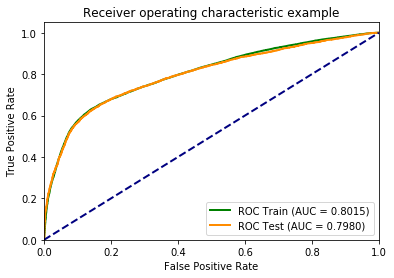

In [22]:
# Notice that precision, recall, and f1-score are returned for label 1, not label 0.
# Model 1
get_performance_metrics(y_train=y_train, 
                        y_train_pred=model_1.predict_proba(train_standardized_data)[:,1], 
                        y_test=y_test, 
                        y_test_pred=model_1.predict_proba(test_standardized_data)[:,1], 
                        threshold=0.5)
plot_roc_curve(y_train=y_train, 
               y_train_pred=model_1.predict_proba(train_standardized_data)[:, 1], 
               y_test=y_test, 
               y_test_pred=model_1.predict_proba(test_standardized_data)[:,1])

              train      test
metrics                      
AUC        0.800367  0.796371
Accuracy   0.501659  0.503146
Precision  0.500660  0.502262
Recall     0.999863  0.999864
f1-score   0.667222  0.668643


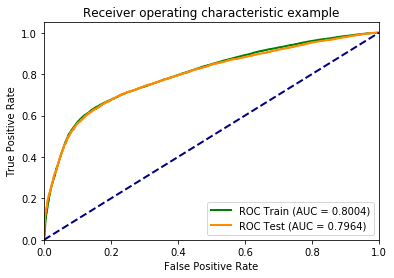

In [23]:
# Model 2
get_performance_metrics(y_train=y_train, 
                        y_train_pred=model_2.predict_proba(train_standardized_data)[:,1], 
                        y_test=y_test, 
                        y_test_pred=model_2.predict_proba(test_standardized_data)[:,1], 
                        threshold=0.5)
plot_roc_curve(y_train=y_train, 
               y_train_pred=model_2.predict_proba(train_standardized_data)[:, 1], 
               y_test=y_test, 
               y_test_pred=model_2.predict_proba(test_standardized_data)[:,1])

In [24]:
# Model 1 - metric report
print(classification_report(y_true=y_test, 
                            y_pred=model_1.predict(test_standardized_data)))

              precision    recall  f1-score   support

           0       0.70      0.86      0.77      7290
           1       0.81      0.63      0.71      7330

   micro avg       0.74      0.74      0.74     14620
   macro avg       0.76      0.74      0.74     14620
weighted avg       0.76      0.74      0.74     14620



In [25]:
# Model 2 - metric report
print(classification_report(y_true=y_test, 
                            y_pred=model_2.predict(test_standardized_data)))

              precision    recall  f1-score   support

           0       0.96      0.00      0.01      7290
           1       0.50      1.00      0.67      7330

   micro avg       0.50      0.50      0.50     14620
   macro avg       0.73      0.50      0.34     14620
weighted avg       0.73      0.50      0.34     14620



In [26]:
# Model 1 - Confusion Matrix
pd.DataFrame(confusion_matrix(y_test, 
                              y_pred=model_1.predict(test_standardized_data)), 
             columns=['Pred 0', 'Pred 1'],
             index = ['True 0', 'True 1'])

,Pred 0,Pred 1
True 0,6237,1053
True 1,2722,4608


In [27]:
# Model 2 - Confusion Matrix
pd.DataFrame(confusion_matrix(y_test, 
                              y_pred=model_2.predict(test_standardized_data)), 
             columns=['Pred 0', 'Pred 1'],
             index = ['True 0', 'True 1'])

,Pred 0,Pred 1
True 0,27,7263
True 1,1,7329


# 4. Hyperparameter Tuning - SGD classifier
- 4.1 Bayesian Optimization 
    - 4.1.1 Bayesian Optimization - Include class_weight
- 4.2 Continue Bayesian Optimization

## 4.1 Bayesian Optimization 

In [ ]:
# Define the search space
space = {
    'loss':'log',
    'penalty': hp.choice('penalty', ['none', 'l2', 'l1', 'elasticnet']),
    'alpha': hp.uniform('alpha', 0.0001, 100.0),
    'l1_ratio': hp.uniform('l1_ratio', 0.0, 1.0),
    'fit_intercept':hp.choice('fit_intercept', [True, False]),
    'random_state':0
}

### 4.1.1 Bayesian Optimization - Include class_weight

In [ ]:
# Define the search space
space = {
    'loss':'log',
    'penalty': hp.choice('penalty', ['none', 'l2', 'l1', 'elasticnet']),
    'alpha': hp.uniform('alpha', 0.0001, 100.0),
    'l1_ratio': hp.uniform('l1_ratio', 0.0, 1.0),
    'fit_intercept':hp.choice('fit_intercept', [True, False]),
    'random_state':0,
    'class_weight':{0:0.1,1:0.9}
}

In [ ]:
# Define the objective (here is to minimize mse)
def objective(hyperparameters):
    
    """Objective function for multiple linear regression hyperparameter optimization."""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    start = timer()
    
    # Perform 5-fold cross validation
    model = SGDClassifier(**hyperparameters)
    cv_results = cross_validate(model, train_standardized_data, y_train, 
                                scoring='roc_auc', cv=5, 
                                return_train_score=False)
    run_time = timer() - start
    
    # Loss must be minimized (put a negative sign)
    loss = -(np.mean(cv_results['test_score']))

    # Write searching results to a csv file ('a' means append)
    of_connection = open(OUT_FILE, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, hyperparameters, ITERATION, run_time])
    of_connection.close()

    # Dictionary with information for evaluation
    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}

In [ ]:
# Record results
trials = Trials()

In [ ]:
# Create a file and open a connection
#OUT_FILE = 'OS_SGD_Logistic_Regression.csv'
OUT_FILE = 'OS_CW_SGD_Logistic_Regression.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

ITERATION = 0

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime']
writer.writerow(headers)
of_connection.close()

In [ ]:
# Run 100 evaluations
MAX_EVALS = 100

# Global variable
global ITERATION

ITERATION = 0

# Run optimization
best = fmin(fn = objective, 
            space = space, 
            algo = tpe.suggest, 
            trials = trials,
            max_evals = MAX_EVALS)

best

In [ ]:
# Sort the trials with the lowest loss first
trials_dict = sorted(trials.results, key = lambda x: x['loss'], reverse=False)
trials_dict[0]

## 4.2 Continue Bayesian Optimization

In [ ]:
# Save the trial results to a json file for later continuing training
#with open('OS_SGD_Logistic_Regression.json', 'w') as f:
    #f.write(json.dumps(trials_dict))
    
with open('OS_CW_SGD_Logistic_Regression.json', 'w') as f:
    f.write(json.dumps(trials_dict))

In [ ]:
# Read back the Trail object
#with open('OS_SGD_Logistic_Regression.json') as f:
    #last_x_trail = json.load(f)
    
with open('OS_CW_SGD_Logistic_Regression.json') as f:
    last_x_trail = json.load(f)

# See how many iterations finished before
print(len(last_x_trail))

In [ ]:
# Continue Bayesian Optimization by doing x more times 
# Notice: Must specify the last searched trail object 
MAX_EVALS = 1000
trials = Trials(last_x_trail)

best = fmin(fn = objective, 
            space = space, 
            algo = tpe.suggest, 
            trials = trials,
            max_evals = MAX_EVALS)
best

In [ ]:
# See the lowest loss
cont_trials_dict = sorted(trials.results, key = lambda x: x['loss'], reverse=False)
cont_trials_dict[0]

In [ ]:
# Append the original searched result
for each_iteration_result in cont_trials_dict:
    trials_dict.append(each_iteration_result)
    
# Inspect the number of searching
len(trials_dict)

In [ ]:
# Save the result in a json file
#with open('OS_SGD_Logistic_Regression.json', 'w') as f:
    #f.write(json.dumps(trials_dict))

with open('OS_CW_SGD_Logistic_Regression.json', 'w') as f:
    f.write(json.dumps(trials_dict))

In [ ]:
#params_result = pd.read_csv('OS_SGD_Logistic_Regression.csv')
#params_result.head()

params_result = pd.read_csv('OS_CW_SGD_Logistic_Regression.csv')
params_result.head()

In [ ]:
# The optimal model
params_result.sort_values(by = 'loss').head(5)

In [ ]:
params_result.sort_values(by = 'loss').head(1)['hyperparameters'].values

# 5. Result comparison

In [29]:
# Helper function of plotting different scores given differnt threshold values.
def threshold_metric_visualization(y_test, prediction):
    accuracy_score_ls = []
    precision_score_ls = []
    recall_score_ls = []
    f1_score_ls = []
    threshold_ls = []
    predictions = prediction
    
    # Loop through different thresholds ranged from 0 to 1.
    for threshold in np.arange(0, 1, 0.1):
        threshold_ls.append(threshold)
        accuracy_score_ls.append(accuracy_score(y_test, predictions>threshold))
        precision_score_ls.append(precision_score(y_test, predictions>threshold))
        recall_score_ls.append(recall_score(y_test, predictions>threshold))
        f1_score_ls.append(f1_score(y_test, predictions>threshold))
    
    plt.figure(figsize=(10,6))
    plt.plot(threshold_ls,accuracy_score_ls)
    plt.plot(threshold_ls,precision_score_ls)
    plt.plot(threshold_ls,recall_score_ls)
    plt.plot(threshold_ls,f1_score_ls)
    plt.legend(['accuracy', 'precision', 'recall', 'f1-score'], loc = 'best')
    plt.xlabel('threshold')
    plt.ylabel('score')

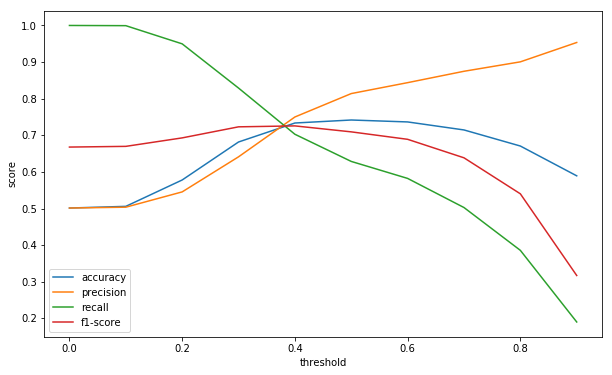

In [30]:
# Model 1
threshold_metric_visualization(y_test=y_test, 
                               prediction=model_1.predict_proba(test_standardized_data)[:,1])

In [31]:
# Threshold decision: Model 1 

# I chose the threshold at 0.3 since at this point, the model can achieve favorable
# precision and recall score at the same time.
# However, I treated the recall score more important than precision because my objective
# is to identify the 'subscribed' customers among all subscribed customers correctly.

# A higher precision score means that among the predictions, 
# how many are correctly predicted as the true ground choices.

# A higher recall score indicates that among the true ground choices, 
# how many are correctly predicted.
pd.DataFrame(confusion_matrix(y_test, 
                              y_pred=model_1.predict_proba(test_standardized_data)[:, 1] > 0.3), 
             columns=['Pred 0', 'Pred 1'],
             index = ['True 0', 'True 1'])

,Pred 0,Pred 1
True 0,3890,3400
True 1,1253,6077


In [32]:
print('Model 1: When the threshold is 0.3, the precision score is {} and the recall is {}.'.\
      format(round(6077/(3400+6077), 4), round(6077/(1253+6077), 4)))

Model 1: When the threshold is 0.3, the precision score is 0.6412 and the recall is 0.8291.


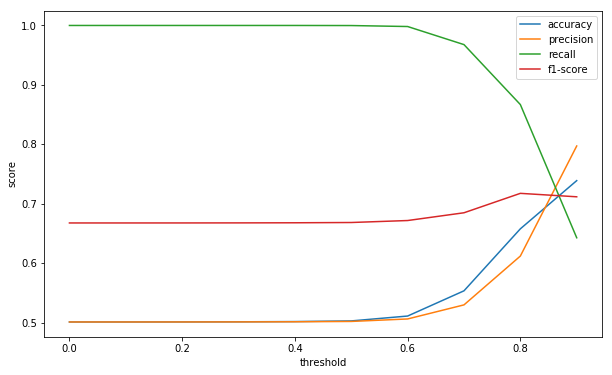

In [33]:
# Model 2
threshold_metric_visualization(y_test=y_test, 
                               prediction=model_2.predict_proba(test_standardized_data)[:,1])

In [34]:
pd.DataFrame(confusion_matrix(y_test, 
                              y_pred=model_2.predict_proba(test_standardized_data)[:, 1] > 0.8), 
             columns=['Pred 0', 'Pred 1'],
             index = ['True 0', 'True 1'])

,Pred 0,Pred 1
True 0,3265,4025
True 1,975,6355


In [35]:
print('Model 2: When the threshold is 0.8, the precision score is {} and the recall is {}.'.\
      format(round(6325/(3940+6325), 4), round(6325/(1005+6325), 4)))

Model 2: When the threshold is 0.8, the precision score is 0.6162 and the recall is 0.8629.


**Notice: Metrics including precision, recall, and f1-score are returned at the threshold = 0.5 on the same test data among three models.**

|Model|Precision| Recall| F1-score | AUC | 
| - | - | - | - | - | 
|Unbalanced Labels SGDclassifier| 0.72 | 0.22 | 0.34 | 0.7911 |
|Balanced Labels (SMOTE) SGDclassifier| **0.81** | 0.63 | **0.71** | **0.7980**| 
|Balanced (SMOTE) & Adjusted Penalties on Labels SGDclassifier | 0.50 | **1.00** | 0.67 | 0.7965 |

From the above summary table, using SMOTE over-sampling improved the model performance in each metric. Among three models, I chose the second one since it achieved the highest AUC and if I set the threshold at 0.3, the corresponding recall score is 0.8291, which is not bad.

# 6. Summary
- 6.1 Less important features
    - 6.1.1 Coefficients = 0
    - 6.1.2 The top 5 least important features
- 6.2 Important features - Interpreting coefficients

## 6.1 Less important features

### 6.1.1 Coefficients = 0

In [36]:
# 0 coefficients (betas)
# If the coefficient of a predictor is pushed to 0, then this predictor doesn't play
# any significant role in predictions.
i = 0
for index in abs(model_1.coef_.flatten()).argsort():
    if model_1.coef_.flatten()[index] == 0:
        print('Coefficient of column {} is {}.'.format(
            x_train.columns[index],
            round(model_1.coef_.flatten()[index], 4)
             ))
        i+=1
print()
print('{} coefficients of predictors were pushed to 0.'.format(i))


0 coefficients of predictors were pushed to 0.


### 6.1.2 The top 5 least important features

In [37]:
i = 0
for index in abs(model_1.coef_.flatten()).argsort():
    if model_1.coef_.flatten()[index] != 0 and i<5:
        print('Coefficient of column {} is {}.'.format(
            x_train.columns[index],
            round(model_1.coef_.flatten()[index], 4)))
        i+=1

Coefficient of column job_unknown is -0.0009.
Coefficient of column education_basic.6y is 0.0014.
Coefficient of column marital_unknown is 0.0017.
Coefficient of column day_of_week_fri is -0.002.
Coefficient of column day_of_week_thu is 0.0025.


## 6.2 Important features - Interpreting coefficients

In [38]:
# The top 5 most important negative predictors.
i = 0
for index in model_1.coef_.flatten().argsort():
    if model_1.coef_.flatten()[index] != 0 and i<5:
        print('Coefficient of column {} is {}.'.format(
            x_train.columns[index],
            round(model_1.coef_.flatten()[index], 4)))
        i+=1

Coefficient of column emp_var_rate is -1.4962.
Coefficient of column pdays is -0.3754.
Coefficient of column contact is -0.2825.
Coefficient of column month_may is -0.1876.
Coefficient of column campaign is -0.1522.


In [39]:
# The top 5 most important positive predictors.
i = 0
for index in model_1.coef_.flatten().argsort()[::-1]:
    if model_1.coef_.flatten()[index] != 0 and i<5:
        print('Coefficient of column {} is {}.'.format(
            x_train.columns[index],
            round(model_1.coef_.flatten()[index], 4)))
        i+=1

Coefficient of column cons_price_idx is 0.6869.
Coefficient of column euribor3m is 0.3581.
Coefficient of column month_mar is 0.208.
Coefficient of column month_aug is 0.1162.
Coefficient of column cons_conf_idx is 0.1074.


#### Increasing the feature value by 1 decreases logit odds by theta and odds by the exponential of theta.

| Negative Feature |$$\theta$$| $$e^\theta$$ |
| - | - | - |
| emp_var_rate | -1.4962 | 0.2240 |
| pdays | -0.3754 | 0.6870 |
| contact | -0.2825 | 0.7539 | 
| month_may | -0.1876 | 0.8289 | 
| campaign | -0.1522 | 0.8588 |

#### Increasing the feature value by 1 increases logit odds by theta and odds by the exponential of theta.

| Positive Feature |$$\theta$$| $$e^\theta$$ |
| - | - | - |
| cons_price_idx | 0.6869 | 1.9875 |
| euribor3m | 0.3581 | 1.4306 |
| month_mar | 0.2080 | 1.2312 | 
| month_aug | 0.1162 | 1.1232 | 
| cons_conf_idx | 0.1074 | 1.1134 |

#### Recommendations
- Nagative Features
    - Uncontrollable
        - emp_var_rate: Employment variation rate - quarterly indicator. -> The less the better.
    - Controllable
        - pdays: Number of days that passed by after the client was last contacted from a previous campaign. -> **The less the better.** The longer the days that passed after the last contact, the less probobability to subscribe the term.
        - contact: Contact communication type (0: 'cellular', 1: 'telephone'). -> **Clients contacted by the cellular tended to subscribe terms.**
        - month_may: Last contact month of year. -> **The last time clients contacted on May are less likely to subscribe terms.**
        - campaign: Number of contacts performed during this campaign and for this client. -> **The less contacts to the clients, the higher probobability to subscribe term.** Clients might feel annoying or disturbing when they contacted too much time.
- Positive Features
    - Uncontrollable
        - cons_price_idx (CPI): Consumer price index - monthly indicator. 
        - euribor3m: Euribor 3 month rate - daily indicator.
        - cons_conf_idx: consumer confidence index - monthly indicator. 
    - Controllable
        - month_mar: Last contact month of year. -> **The last time clients contacted on March are more likely to subscribe terms.**
        - month_aug: Last contact month of year. -> **The last time clients contacted on August are more likely to subscribe terms.**